In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files

# 1: DATA LOADING AND PREPROCESSING
print("\n 1: Loading and Preprocessing Data ")

# Text cleaning function
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)                 # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)           # Remove non-alphanumeric characters
    text = text.lower()                               # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()          # Remove extra whitespace
    return text

# Upload the dataset zip file
print("Please upload the 'archive.zip' file.")
uploaded = files.upload()

# Unzip and load the data
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

fake_df = pd.read_csv('/content/data/Fake.csv')
true_df = pd.read_csv('/content/data/True.csv')

# ADDRESSING DATA LEAKAGE
true_df['text'] = true_df['text'].apply(lambda x: x.split(' - ', 1)[-1])

# Add labels: 1 for Fake, 0 for Real
fake_df['label'] = 1
true_df['label'] = 0

# Combine, shuffle, and apply the cleaning function
df = pd.concat([fake_df, true_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = (df['title'].astype(str) + ' ' + df['text'].astype(str)).apply(clean_text)
df = df[['content', 'label']]

print(f"\nDataset loaded successfully with {len(df)} articles.")
print("Class distribution:\n", df['label'].value_counts())

# Split the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, Y_train, Y_temp = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)

print(f"\nData Split:")
print(f"Training data size:   {len(X_train)}")
print(f"Validation data size: {len(X_val)}")
print(f"Test data size:       {len(X_test)}")

 Installing and Importing Libraries 

--- Section 1: Loading and Preprocessing Data ---
Please upload the 'archive.zip' file.


Saving archive.zip to archive.zip

Dataset loaded successfully with 44898 articles.
Class distribution:
 label
1    23481
0    21417
Name: count, dtype: int64

Data Split:
Training data size:   35918
Validation data size: 4490
Test data size:       4490


In [ ]:
# 2: DEFINING THE DISTILBERT MODEL
print("\n Defining Tokenizer and DistilBERT Model")

# Model Parameters
MAX_LEN = 128  # Larger length can  capture more context
MODEL_NAME = 'distilbert-base-uncased'

# 2.1 Load DistilBERT Tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def tokenize(X):

    return distilbert_tokenizer(
        text=list(X), add_special_tokens=True, max_length=MAX_LEN,
        truncation=True, padding='max_length', return_tensors='tf',
        return_attention_mask=True, verbose=True
    )

# Custom Keras Layer to wrap the transformer model
class TransformerFeatureExtractor(Layer):
    def __init__(self, transformer_model, **kwargs):
        super(TransformerFeatureExtractor, self).__init__(**kwargs)
        self.transformer = transformer_model

    def call(self, inputs):
        # We only need the last hidden state from the base model
        return self.transformer(inputs).last_hidden_state

# 2.2 Define the DistilBERT Model Architecture
def create_distilbert_model(transformer_model, max_len=MAX_LEN):

    # Freeze the pre-trained DistilBERT layers
    transformer_model.trainable = False

    # Define the input layers
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Get the feature embeddings from the base model
    feature_extractor = TransformerFeatureExtractor(transformer_model)
    bert_output = feature_extractor({'input_ids': input_ids, 'attention_mask': attention_mask})

    # Use Global Average Pooling to create a single vector representation
    pooled_output = GlobalAveragePooling1D()(bert_output)

    # Add regularization and classification layers
    x = Dropout(0.4)(pooled_output)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid", name="classification")(x)

    # Create and return the final model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Instantiate the pre-trained DistilBERT model
distilbert_base_model = TFDistilBertModel.from_pretrained(MODEL_NAME, from_pt=True)

# Create the full classification model
model = create_distilbert_model(distilbert_base_model, max_len=MAX_LEN)

print("\nDistilBERT Model Architecture:")
model.summary()


 Defining Tokenizer and DistilBERT Model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode


DistilBERT Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_featur… │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (TransformerFeatur… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ transformer_feat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     49,216 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3: TRAINING THE MODEL
print("\n Training the Model")

# Tokenize all data splits
print("Tokenizing data...")
X_train_token = tokenize(X_train)
X_val_token = tokenize(X_val)
X_test_token = tokenize(X_test)

# Define a robust optimizer and callbacks for better training
optimizer = Adam(learning_rate=2e-5, epsilon=1e-08)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1, min_lr=1e-7)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model using the training and validation sets
print("\nStarting model training...")
history = model.fit(
    x={'input_ids': X_train_token['input_ids'], 'attention_mask': X_train_token['attention_mask']},
    y=Y_train,
    validation_data=(
        {'input_ids': X_val_token['input_ids'], 'attention_mask': X_val_token['attention_mask']},
        Y_val
    ),
    epochs=8,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



 Training the Model
Tokenizing data...

Starting model training...
Epoch 1/8
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 165s 137ms/step - accuracy: 0.6504 - loss: 0.6248 - val_accuracy: 0.9114 - val_loss: 0.3441 - learning_rate: 2.0000e-05
Epoch 2/8
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 197s 137ms/step - accuracy: 0.8780 - loss: 0.3533 - val_accuracy: 0.9218 - val_loss: 0.2380 - learning_rate: 2.0000e-05
Epoch 3/8
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 152s 136ms/step - accuracy: 0.8995 - loss: 0.2747 - val_accuracy: 0.9263 - val_loss: 0.2028 - learning_rate: 2.0000e-05
Epoch 4/8
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 156s 139ms/step - accuracy: 0.9090 - loss: 0.2406 - val_accuracy: 0.9314 - val_loss: 0.1847 - learning_rate: 2.0000e-05
Epoch 5/8
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 153s 136ms/step - accuracy: 0.9130 - loss: 0.2296 - val_accuracy: 0.9354 - val_loss: 0.1732 - learning_rate: 2.0000e-05
Epoch 6/8
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 201s 135ms/step - accuracy: 0.9173 - loss: 0.2148 - val_accuracy: 0.9383 - val_loss: 0


 Evaluating the Model
Plotting model training history


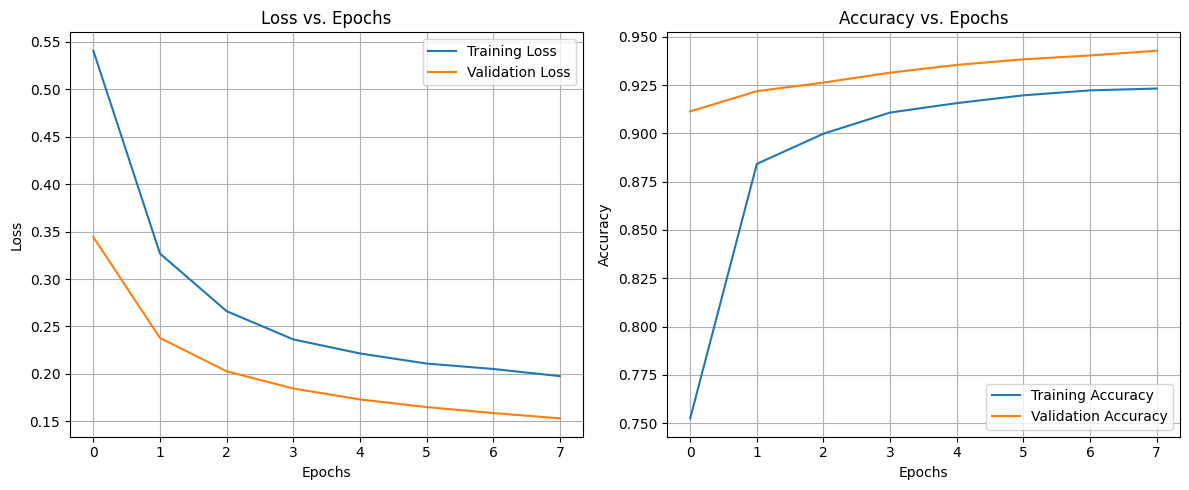


Making predictions on the held-out test set...
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

    Real (0)       0.94      0.93      0.94      2142
    Fake (1)       0.94      0.94      0.94      2348

    accuracy                           0.94      4490
   macro avg       0.94      0.94      0.94      4490
weighted avg       0.94      0.94      0.94      4490


Confusion Matrix:


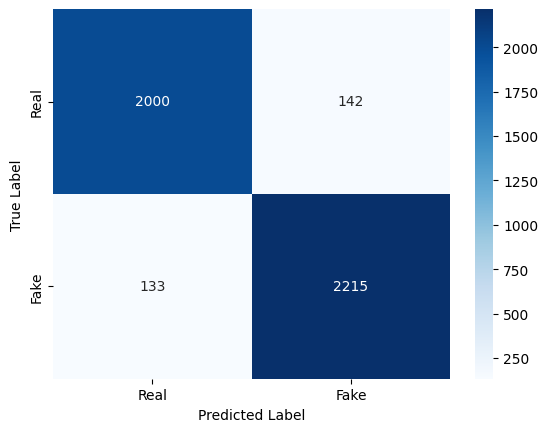

In [ ]:
# 4: EVALUATING THE MODEL
print("\n Evaluating the Model")

# 4.1 Plot training history
print("Plotting model training history")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4.2 Make predictions on the unseen test set
print("\nMaking predictions on the held-out test set...")
predicted_probabilities = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})
binary_predictions = (predicted_probabilities > 0.5).astype(int)

# 4.3 Generate Classification Report and Confusion Matrix
print("\nClassification Report on Test Set:")
print(classification_report(Y_test, binary_predictions, target_names=['Real (0)', 'Fake (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y_test, binary_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# 5: SAVING THE MODEL
import json
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define a unique output directory for this model
output_dir = Path("/content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"\nArtifacts will be saved to: {output_dir}")

# Save the model weights
weights_path = output_dir / "model.weights.h5"
model.save_weights(str(weights_path))
print(f" Model weights saved successfully to: {weights_path}")

# Save the tokenizer
tokenizer_path = output_dir / "tokenizer"
distilbert_tokenizer.save_pretrained(str(tokenizer_path))
print(f" Tokenizer saved successfully to: {tokenizer_path}")

# Save the configuration file
config = {
    "model_name": MODEL_NAME,
    "max_len": MAX_LEN,
    "threshold": 0.5
}
config_path = output_dir / "config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f" Model configuration saved successfully to: {config_path}")

print("\n All artifacts saved")

Mounted at /content/drive

Artifacts will be saved to: /content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert
 Model weights saved successfully to: /content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert/model.weights.h5
 Tokenizer saved successfully to: /content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert/tokenizer
 Model configuration saved successfully to: /content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert/config.json

 All artifacts saved


In [ ]:
#  6: LOADING AND TESTING THE SAVED MODEL
import json
from pathlib import Path
from transformers import AutoTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Layer
from tensorflow.keras.models import Model
import tensorflow as tf

print("\n 6: Loading and Testing the Saved Model ---")

# Define the path where your model was saved
ARTIFACTS_DIR = Path("/content/drive/MyDrive/fake_news_models_distil/Latest_DistilBert")

# 1) Load Model Configuration
config_path = ARTIFACTS_DIR / "config.json"
config = json.loads(config_path.read_text())
model_name_loaded = config["model_name"]
max_len_loaded = int(config["max_len"])
threshold_loaded = float(config["threshold"])
print(" Model configuration loaded successfully.")

# 2) Load the Tokenizer
tokenizer_dir = ARTIFACTS_DIR / "tokenizer"
tokenizer_loaded = AutoTokenizer.from_pretrained(str(tokenizer_dir))
print(" Tokenizer loaded successfully.")

# 3) Rebuild the EXACT SAME Model Architecture
def build_reloaded_distilbert_model(model_name, max_len):
    # The custom layer must be redefined to be recognized by Keras
    class TransformerFeatureExtractor(Layer):
        def __init__(self, transformer_model, **kwargs):
            super(TransformerFeatureExtractor, self).__init__(**kwargs)
            self.transformer = transformer_model
        def call(self, inputs):
            return self.transformer(inputs).last_hidden_state

    base_model = TFDistilBertModel.from_pretrained(model_name, from_pt=True)
    base_model.trainable = False
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
    feature_extractor = TransformerFeatureExtractor(base_model)
    bert_output = feature_extractor({'input_ids': input_ids, 'attention_mask': attention_mask})
    pooled_output = GlobalAveragePooling1D()(bert_output)
    x = Dropout(0.4)(pooled_output)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid", name="classification")(x)
    reloaded_model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return reloaded_model

# Instantiate the empty model structure
reloaded_model = build_reloaded_distilbert_model(model_name_loaded, max_len_loaded)
print(" Model architecture rebuilt successfully.")

# 4) Load the Saved Weights
# The filename has been updated to match what was saved.
weights_path = ARTIFACTS_DIR / "model.weights.h5"
reloaded_model.load_weights(str(weights_path))
print(" Model weights loaded successfully.")

# 5) Quick Sanity Check
print("\n--- Quick Demonstration ---")
demo_texts = [
    "Washington D.C. - Lawmakers reached a bipartisan agreement on the new budget late Tuesday evening, officials say.",
    "You won't believe what they found on Mars! A secret government source revealed aliens are already here."
]
encoded_texts = tokenizer_loaded(demo_texts, truncation=True, padding="max_length", max_length=max_len_loaded, return_tensors="tf")
probabilities = reloaded_model.predict(dict(encoded_texts)).flatten()
predictions = (probabilities >= threshold_loaded).astype(int)

for text, prob, pred in zip(demo_texts, probabilities, predictions):
    label = "FAKE" if pred == 1 else "REAL"
    print(f"\nText: \"{text[:60]}...\"")
    print(f"  -> Probability (Fake): {prob:.4f} | Prediction: {label}")


--- Section 6: Loading and Testing the Saved Model ---
 Model configuration loaded successfully.
 Tokenizer loaded successfully.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


 Model architecture rebuilt successfully.
 Model weights loaded successfully.

--- Quick Demonstration ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Text: "Washington D.C. - Lawmakers reached a bipartisan agreement o..."
  -> Probability (Fake): 0.0039 | Prediction: REAL

Text: "You won't believe what they found on Mars! A secret governme..."
  -> Probability (Fake): 0.9804 | Prediction: FAKE


In [ ]:
# 7: DEPLOYING WITH GRADIO
print("\n--- Section 6: Building the Gradio Web Interface ---")
!pip install gradio -q
import gradio as gr

# The model and tokenizer are already loaded and verified from the previous section.
# We will use 'reloaded_model' and 'tokenizer_loaded'.

# STEP 1: DEFINE PREDICTION AND CLEANING FUNCTIONS
def predict_fake_news(text):
    """
    Cleans the input text, tokenizes it, and uses the loaded model to predict
    if the news is REAL or FAKE.
    """
    # Clean the input text
    cleaned_text = clean_text(text)

    # Tokenize the cleaned text using the loaded tokenizer
    inputs = tokenizer_loaded(
        text=cleaned_text,
        add_special_tokens=True,
        max_length=max_len_loaded,  # Use the max_len from the loaded config
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # Make a prediction using the reloaded model
    prediction_score = reloaded_model.predict({
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    })[0][0]

    # Calculate probabilities for both labels
    fake_prob = float(prediction_score)
    real_prob = 1 - fake_prob

    # Return the result in the format Gradio expects for a Label output
    return {'FAKE': fake_prob, 'REAL': real_prob}

# STEP 2: LAUNCH THE GRADIO INTERFACE
# Define some example articles for the user to try
examples = [
    ["BREAKING: A source close to the White House claims the president is secretly a lizard person. The evidence is undeniable, experts say."],
    ["The S&P 500 closed up 0.5% on Tuesday after the Federal Reserve announced it would hold interest rates steady, citing stable inflation figures."],
    ["You will be SHOCKED to learn about this one weird trick to lose weight. Doctors don't want you to know this simple secret."]
]

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_fake_news,
    inputs=gr.Textbox(lines=8, placeholder="Paste a news article, headline, or text snippet here..."),
    outputs=gr.Label(num_top_classes=2, label="Verdict"),
    title="DistilBERT Fake News Detector",
    description="This interface uses a fine-tuned DistilBERT model to classify text as REAL or FAKE. Paste an article below and see the model's prediction.",
    examples=examples
)

# Launch the interface
interface.launch(debug=True)


--- Section 6: Building the Gradio Web Interface ---
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8fbdbbe978d177bd8d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
